In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import os, sys
import logging

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from aiutils import copy_logistic_model, load, save
from actioncard import Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch
from config import GameConfig
from constants import BUY, ACTION
from enums import StartingSplit, FeatureType
from env import DefaultEnvironment
from mcts import GameTree 
from mctsrunner import train_mcts
from player import init_players, load_players
from rollout import LogisticRegressionEnsembleRollout
from victorycard import Province

In [6]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

In [7]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
# logger.setLevel(BUY)
# logger.setLevel(ACTION)

In [5]:
log_dir = os.path.join(project_root, 'logs')
log_path = os.path.join(log_dir, 'temp.log')

In [9]:
full_tree_name = 'full-paper-tree-uniform-160k'

In [5]:
write_tree_path = os.path.join(model_dir, 'full-paper-tree-160k-boost-1m')
write_rollout_path = os.path.join(model_dir, 'temp-rollout')

In [8]:
default_kingdom = [Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch]

## Full Dominion: Extra Tree Training ##

In [10]:
tree_name = full_tree_name
rollout_name = 'default-mlog-full-paper'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [11]:
C = lambda x: max(1 / np.sqrt(x + 2), 0.1)
tree = GameTree.load(path=tree_path, train=True, C=C, _skip_level=False)

In [12]:
config = GameConfig(splits=[StartingSplit.UniformRandomSplit, StartingSplit.UniformRandomSplit] , sandbox=False, num_players=2, must_include=default_kingdom)
player = load_players(['UCT'], [rollout_path], train=False, tree=tree, rollout_type='mlog', use_tree=True)[0]
players = [player, player]
agent = players[0]
# opp = players[1]
env = DefaultEnvironment(config, players)
idxs = env.game.state.feature.idxs 

In [13]:
train_mcts(env=env, tree=tree, epochs=840000, train_epochs_interval=sys.maxsize, save_epochs=10000, path=write_tree_path, rollout_path=write_rollout_path, scoring='score_ratio')

100%|██████████| 4000/4000 [02:08<00:00, 31.19it/s]


In [14]:
tree._root.children

[Parent: None << (n: 40618, v: 10283.304895584268, Q: 0.253 c: None) >> Children: [(0, 'Copper', '1695', '0.282'), (1, 'Estate', '519', '0.265'), (2, 'Chapel', '31635', '0.310'), (3, 'Moat', '4357', '0.290'), (4, 'None', '2412', '0.286')],
 Parent: None << (n: 41458, v: 10422.2110343068, Q: 0.251 c: None) >> Children: [(0, 'Copper', '1166', '0.281'), (1, 'Estate', '512', '0.267'), (2, 'Silver', '33723', '0.303'), (3, 'Chapel', '634', '0.271'), (4, 'Moat', '2893', '0.291'), (5, 'Village', '1201', '0.282'), (6, 'None', '1329', '0.283')],
 Parent: None << (n: 41832, v: 10284.154350409206, Q: 0.246 c: None) >> Children: [(0, 'Copper', '489', '0.275'), (1, 'Estate', '275', '0.261'), (2, 'Silver', '976', '0.288'), (3, 'Chapel', '244', '0.258'), (4, 'Moat', '1036', '0.288'), (5, 'Village', '531', '0.277'), (6, 'Militia', '35269', '0.312'), (7, 'MoneyLender', '887', '0.286'), (8, 'Smithy', '1649', '0.294'), (9, 'None', '476', '0.275')],
 Parent: None << (n: 40258, v: 9711.506364318453, Q: 0.24

## Full Dominion MCTS ##

In [9]:
# tree_name = 'full-paper-tree-uniform'
tree_name = 'full-paper-tree-160k-trimmed-cdecay'
rollout_name = 'default-mlog-full-paper'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [10]:
# C = lambda x: max(1e-2, min(0.5, 1 / np.sqrt(x)))
C = lambda x: max(1 / np.sqrt(x + 2), 0.1)
# C = lambda x: 1 / np.sqrt(2)
tree = GameTree(train=True, C=C, selection='ucb1', _skip_level=False)

In [28]:
log_path = os.path.join(project_root, 'temp.log')

In [29]:
fh = logging.FileHandler(log_path)
fh.setLevel(ACTION)
logger.addHandler(fh)

In [11]:
config = GameConfig(splits=[StartingSplit.UniformRandomSplit, StartingSplit.UniformRandomSplit], sandbox=False, num_players=2, must_include=default_kingdom)
player = load_players(['UCT'], [rollout_path], train=False, tree=tree, rollout_type='mlog', use_tree=True)[0]
# players = load_players(['UCT', 'DW'], [rollout_path], train=False, tree=tree, rollout_type='mlog', use_tree=True)
players = [player, player]
agent = players[0]
# opp = players[1]
env = DefaultEnvironment(config, players)
idxs = env.game.state.feature.idxs 

In [32]:
rollout = LogisticRegressionEnsembleRollout(train=False)
agent.rollout = rollout

In [24]:
rollout_name = 'default-mlog-full-paper'
rollout_path = os.path.join(model_dir, rollout_name)
state_dict = load(rollout_path)
warm_models = state_dict['models']

In [30]:
eps = 10e-5
for i, model in warm_models.items(): 
    if i == 0: 
        continue 
    model.coef_[0][24:34] = -eps 
    model.coef_[0][41:51] = eps

In [36]:
save(rollout_path, state_dict)

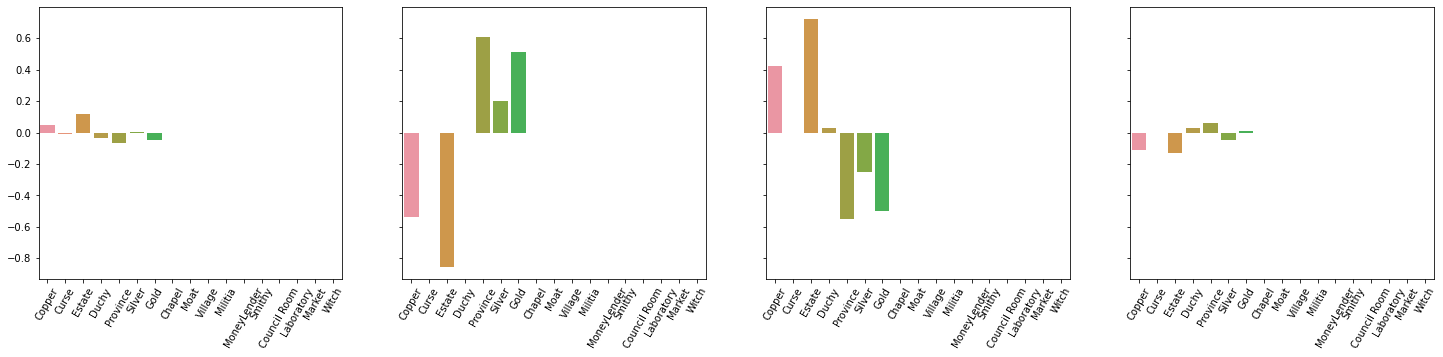

In [13]:
plot_model = agent.rollout.models[8]
# plot_model = warm_models[8]

agent_weights = plot_model.coef_[0][17:34]
opp_weights = plot_model.coef_[0][34:]
supply_weights = plot_model.coef_[0][:17]
player_weight_diffs = agent_weights + opp_weights

cards = [str(k()) for k in idxs.keys()]

f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])
sns.barplot(x=cards, y=player_weight_diffs, ax=axes[3])

for ax in axes: 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

In [14]:
train_mcts(env=env, tree=tree, epochs=160000, train_epochs_interval=sys.maxsize, save_epochs=10000, path=tree_path, rollout_path=rollout_path, scoring='score_ratio')

100%|██████████| 160000/160000 [1:02:15<00:00, 42.83it/s]


In [28]:
tree = GameTree.load(tree_path, train=False, _skip_level=False, selection='max')

## Sandbox MCTS Training ##

In [4]:
from buffer import Buffer

In [14]:
tree_name = 'default-sandbox-uct-paper'
rollout_name = 'default-mlog-sandbox-paper'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [6]:
dataset_name = 'train-bm-bm-2k-full'
data_path = os.path.join(project_root, 'datasets', dataset_name)
raw_data = load(data_path)
X, y = raw_data[0], raw_data[1]

In [15]:
C = lambda x: max(1 / np.sqrt(x + 2), 0.1)
tree = GameTree(train=True, C=C, selection='ucb1', _skip_level=False)

In [9]:
config = GameConfig(splits=[StartingSplit.UniformRandomSplit, StartingSplit.UniformRandomSplit], sandbox=True, num_players=2, must_include=[])
# players = init_players(['UCT', 'DW'], tree=tree, rollout_type='mlog')
# player = init_players(['UCT'], tree=tree, rollout_type='mlog')[0]
player = load_players(['UCT'], [rollout_path], tree=tree, rollout_type='mlog', use_tree=True)[0]
players = [player, player]
agent = players[0]
env = DefaultEnvironment(config, players)
idxs = env.game.state.feature.idxs 

In [9]:
rollout = player.rollout
model_name = 'default-sandbox-warm-start'
model_path = os.path.join(model_dir, model_name)
# models = load(model_path)['models']
model = load(model_path)
rollout.models[8] = copy_logistic_model(model)

# for i, model in models.items():
#     if i == 0:
#         continue
#     rollout.models[i] = copy_logistic_model(model)

In [10]:
idxs = {'Copper': 0, 'Curse': 1, 'Estate': 2, 'Duchy': 3, 'Province': 4, 'Silver': 5, 'Gold': 6}
cards = list(idxs.keys())

In [11]:
filtered_X_idxs = [(i, x) for i, x in enumerate(X) if x[idxs['Province']] > 5]
filtered_X_idxs = [list(t) for t in zip(*filtered_X_idxs)]
filtered_X = filtered_X_idxs[1]
filtered_y = y[filtered_X_idxs[0]]
assert len(filtered_X) == len(filtered_y)
len(filtered_y)

40927

In [12]:
rollout.buffers[8] = Buffer(capacity=5000, locked_capacity=10000)

In [13]:
for i, x in enumerate(filtered_X):
    if i >= 20000:
        break 
    rollout.buffers[8].locked_store(x, filtered_y[i])

In [10]:
player.rollout.train = False

In [13]:
train_mcts(env=env, tree=tree, epochs=100000, train_epochs_interval=sys.maxsize, train_epochs_cap=sys.maxsize, save_epochs=10000, path=tree_path, rollout_path=rollout_path, scoring='score_ratio')

100%|██████████| 100000/100000 [36:46<00:00, 45.33it/s]


<AxesSubplot:>

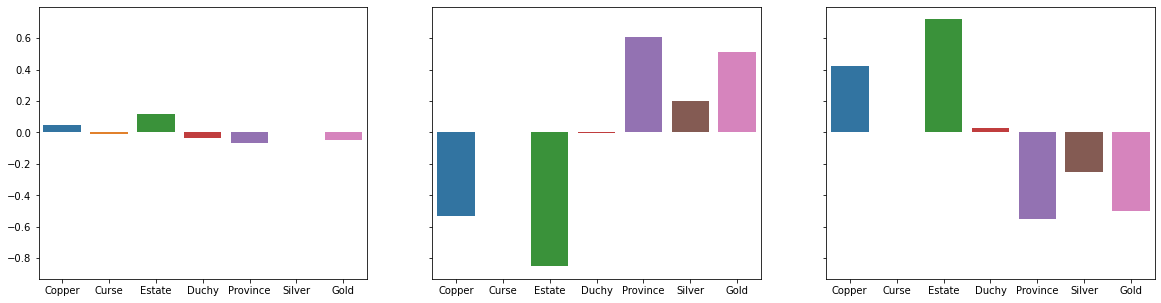

In [12]:
i=8
plot_model = player.rollout.models[8]
# plot_model = test_model

agent_weights = plot_model.coef_[0][7:14]
opp_weights = plot_model.coef_[0][14:]
supply_weights = plot_model.coef_[0][:7]
cards = [str(k()) for k in env.game.state.feature.idxs]

f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])

In [106]:
agent_weights_comp = plot_model.coef_[0][7:14]
opp_weights_comp = plot_model.coef_[0][14:]
supply_weights_comp = plot_model.coef_[0][:7]
cards = list(env.game.state.feature.idxs.keys())

<AxesSubplot:>

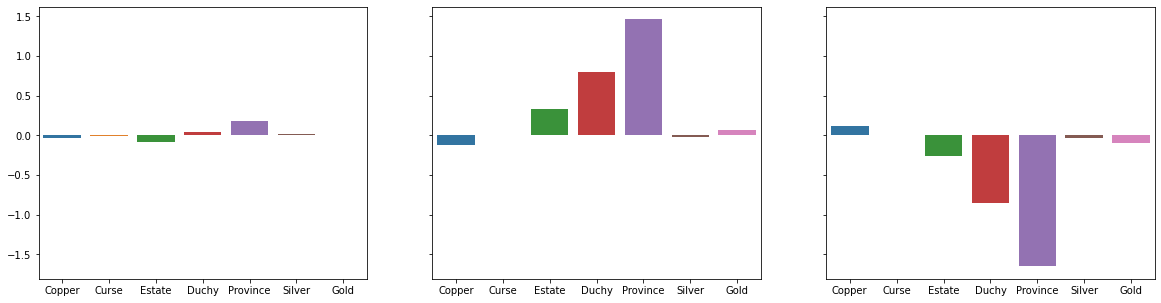

In [107]:
f, axes = plt.subplots(1,3, figsize=(20, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights_comp, ax=axes[0])
sns.barplot(x=cards, y=agent_weights_comp, ax=axes[1])
sns.barplot(x=cards, y=opp_weights_comp, ax=axes[2])